In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


Python version, working dir: /kaggle/working
Train shape: (1460, 81)
Test shape: (1459, 80)
SalePrice skewness: 1.8828757597682129


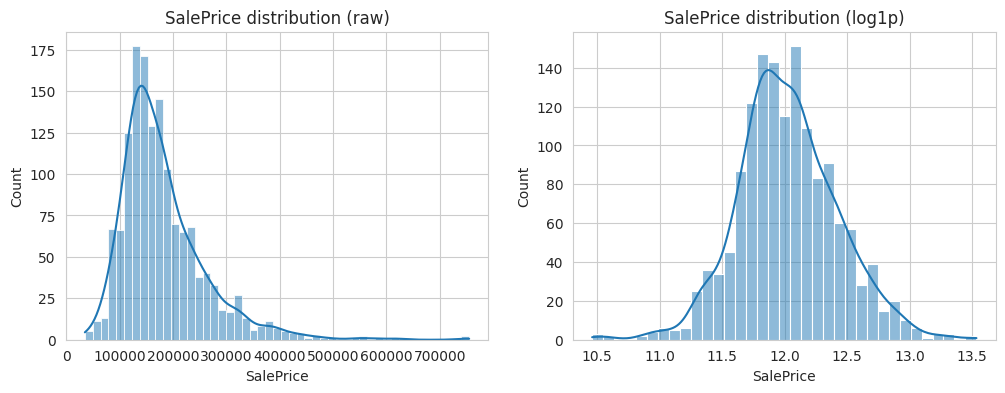

Top missing in train:


,missing_count,missing_pct
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


Top missing in test:


,missing_count,missing_pct
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
MasVnrType,894,0.612748
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageYrBlt,78,0.053461
GarageQual,78,0.053461


Numeric features: 39
Categorical features: 43
Top features correlated with SalePrice (absolute):


SalePrice       1.000000
SalePriceLog    0.948374
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64

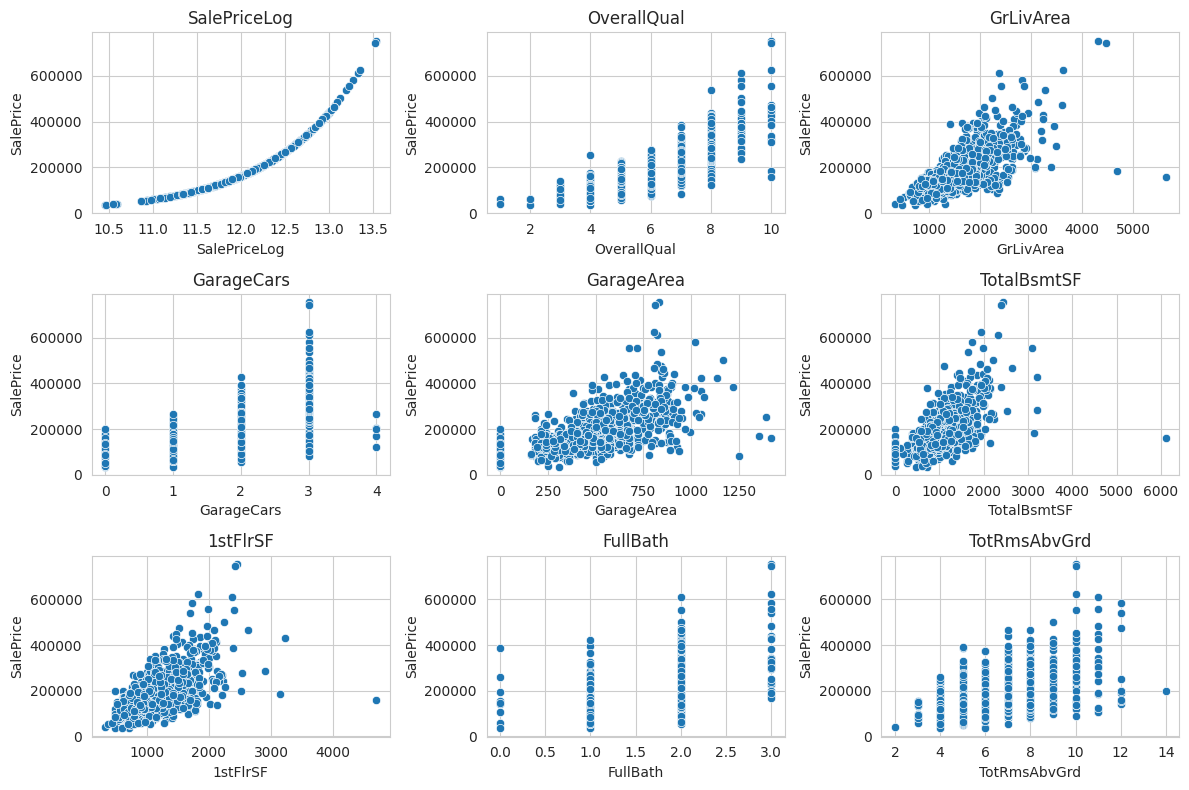

Combined shape: (2919, 80)
After feature engineering: (2919, 91)
Categorical count: 43
X shape: (1460, 91) X_test shape: (1459, 91)
Fitting small RF for quick importance check (this is optional and quick)...


OverallQual*GrLivArea    0.599669
TotalSF                  0.121354
OverallQual              0.050597
TotalBsmtSF              0.018469
GarageCars               0.017334
BsmtFinSF1               0.014829
MSZoning                 0.011660
Age                      0.011107
CentralAir               0.010611
YearBuilt                0.008724
OverallCond              0.008273
LotArea                  0.007700
TotalBath                0.007168
GarageArea               0.006779
RemodAge                 0.006584
GarageYrBlt              0.005968
YearRemodAdd             0.005483
1stFlrSF                 0.005151
GarageType               0.005126
KitchenQual              0.004584
Neighborhood             0.003881
LotFrontage              0.003845
BsmtUnfSF                0.003669
GrLivArea                0.003618
2ndFlrSF                 0.003251
BsmtQual                 0.003235
ExterQual                0.003126
LivAreaPerRoom           0.002878
SaleCondition            0.002841
Id            

In [2]:
# Ames Housing - EDA, Feature Engineering, XGBoost/LightGBM, Stacking, and Submission
# Paste this into a Kaggle notebook. Explanations are in comments and markdown-like prints.

# 0. Imports and basic settings
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import gc
import os
print("Python version, working dir:", os.getcwd())

# Plot style
sns.set_style("whitegrid")

# 1. Load data
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_sub = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

# 2. Quick target check and log transform
print("SalePrice skewness:", train['SalePrice'].skew())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(train['SalePrice'], kde=True)
plt.title('SalePrice distribution (raw)')
plt.subplot(1,2,2)
sns.histplot(np.log1p(train['SalePrice']), kde=True)
plt.title('SalePrice distribution (log1p)')
plt.show()

# We'll use log1p for modeling (common in leaderboard solutions).
train['SalePriceLog'] = np.log1p(train['SalePrice'])

# 3. Basic EDA - missing values, data types, target by features
def missing_summary(df):
    mis = df.isnull().sum()
    mis = mis[mis>0].sort_values(ascending=False)
    return pd.DataFrame({'missing_count':mis, 'missing_pct':mis/len(df)})

print("Top missing in train:")
display(missing_summary(train).head(20))
print("Top missing in test:")
display(missing_summary(test).head(20))

# Quick numeric/categorical split
num_feats = train.select_dtypes(include=[np.number]).columns.tolist()
cat_feats = train.select_dtypes(include=['object']).columns.tolist()
print("Numeric features:", len(num_feats))
print("Categorical features:", len(cat_feats))

# 4. Correlations with target (numeric)
corr = train.select_dtypes(include=[np.number]).corr()['SalePrice'].abs().sort_values(ascending=False)

print("Top features correlated with SalePrice (absolute):")
display(corr.head(20))

# Visualize a few strong correlations
top_num = corr.index[1:10].tolist()  # skip SalePrice itself
plt.figure(figsize=(12,8))
for i, c in enumerate(top_num):
    plt.subplot(3,3,i+1)
    sns.scatterplot(x=train[c], y=train['SalePrice'])
    plt.title(c)
plt.tight_layout()
plt.show()

# 5. Feature engineering ideas (implemented below)
# - TotalSqFt = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
# - TotalBath = FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5*BsmtHalfBath
# - Age (Years since built), RemodAge
# - HasPool, HasGarage, HasPorch boolean flags
# - Label encode categorical variables (trees handle labels)
# - Fill NA for some features with "None" (categorical) or 0 (numeric) based on data dictionary

# 6. Combine train/test for feature engineering convenience
train_idx = train.index
test_idx = test.index
test_ids = test['Id']

all_df = pd.concat([train.drop(columns=['SalePrice','SalePriceLog']), test], axis=0, ignore_index=True)
print("Combined shape:", all_df.shape)

# 7. Implement feature engineering
def feature_engineer(df):
    # Total square footage
    df['TotalSF'] = df['TotalBsmtSF'].fillna(0) + df['1stFlrSF'].fillna(0) + df['2ndFlrSF'].fillna(0)
    # Total bathrooms
    df['TotalBath'] = df['FullBath'].fillna(0) + 0.5*df['HalfBath'].fillna(0) + df['BsmtFullBath'].fillna(0) + 0.5*df['BsmtHalfBath'].fillna(0)
    # Total porch area
    df['TotalPorchSF'] = df['OpenPorchSF'].fillna(0) + df['EnclosedPorch'].fillna(0) + df['3SsnPorch'].fillna(0) + df['ScreenPorch'].fillna(0)
    # Age and Remodel age
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    # Simplify Garage and Basement flags
    df['HasGarage'] = (df['GarageArea'].fillna(0) > 0).astype(int)
    df['HasBsmt'] = (~df['BsmtFinSF1'].isnull()).astype(int)
    df['HasPool'] = (df['PoolArea'].fillna(0) > 0).astype(int)
    # Bedrooms above grade (some suggest total rooms - other rooms)
    df['TotalRooms'] = df['TotRmsAbvGrd'].fillna(0)
    # Living area per room
    df['LivAreaPerRoom'] = df['GrLivArea'].fillna(0) / (df['TotalRooms'].replace(0,1))
    # Interaction features (example)
    df['OverallQual*GrLivArea'] = df['OverallQual'] * df['GrLivArea'].fillna(0)
    # Fill some categorical NAs with 'None' as per data description
    cat_fill_none = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                     'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']
    for c in cat_fill_none:
        if c in df.columns:
            df[c] = df[c].fillna('None')
    # Numeric fill zeros
    num_fill_zero = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath',
                     'MasVnrArea','PoolArea','MiscVal']
    for c in num_fill_zero:
        if c in df.columns:
            df[c] = df[c].fillna(0)
    # Fill LotFrontage by neighborhood median (common trick)
    if 'LotFrontage' in df.columns and 'Neighborhood' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    # Fill remaining categoricals with 'Missing'
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].fillna('Missing')
    # Fill remaining numerics with median
    for c in df.select_dtypes(include=[np.number]).columns:
        df[c] = df[c].fillna(df[c].median())
    return df

all_df = feature_engineer(all_df)
print("After feature engineering:", all_df.shape)

# 8. Label encoding for categorical features (trees handle integer labels well)
obj_cols = all_df.select_dtypes(include=['object']).columns.tolist()
print("Categorical count:", len(obj_cols))
le_dict = {}
for col in obj_cols:
    le = LabelEncoder()
    all_df[col] = le.fit_transform(all_df[col].astype(str))
    le_dict[col] = le

# 9. Split back train/test
X = all_df.iloc[:len(train)]
X_test = all_df.iloc[len(train):].reset_index(drop=True)
y = train['SalePriceLog'].values  # log target

print("X shape:", X.shape, "X_test shape:", X_test.shape)

# 10. Quick feature importance check with a small RandomForest (fast approximate)
print("Fitting small RF for quick importance check (this is optional and quick)...")
rf = RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42, n_jobs=-1)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(importances.head(30))

# 11. Modeling utilities - CV and scoring (RMSE in log-space)
def rmse_log(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


Environment versions: pandas 2.2.3 numpy 1.26.4 xgboost 2.0.3 lightgbm 4.6.0
X shape: (1460, 90) X_test shape: (1459, 90) y shape: (1460,)
Running XGBoost OOF...
XGB Fold 1/5
[0]	train-rmse:0.38076	valid-rmse:0.42310
[1]	train-rmse:0.37125	valid-rmse:0.41310
[2]	train-rmse:0.36222	valid-rmse:0.40362
[3]	train-rmse:0.35314	valid-rmse:0.39398
[4]	train-rmse:0.34470	valid-rmse:0.38529
[5]	train-rmse:0.33615	valid-rmse:0.37606
[6]	train-rmse:0.32813	valid-rmse:0.36744
[7]	train-rmse:0.32018	valid-rmse:0.35966
[8]	train-rmse:0.31240	valid-rmse:0.35200
[9]	train-rmse:0.30477	valid-rmse:0.34467
[10]	train-rmse:0.29766	valid-rmse:0.33731
[11]	train-rmse:0.29053	valid-rmse:0.33040
[12]	train-rmse:0.28380	valid-rmse:0.32390
[13]	train-rmse:0.27716	valid-rmse:0.31764
[14]	train-rmse:0.27077	valid-rmse:0.31140
[15]	train-rmse:0.26454	valid-rmse:0.30510
[16]	train-rmse:0.25874	valid-rmse:0.29906
[17]	train-rmse:0.25286	valid-rmse:0.29342
[18]	train-rmse:0.24720	valid-rmse:0.28822
[19]	train-rmse:0.

,Id,SalePrice
0,1461,121521.411999
1,1462,159115.112737
2,1463,178923.838160
3,1464,185630.624826
4,1465,183809.531588


LightGBM mean feature importance:


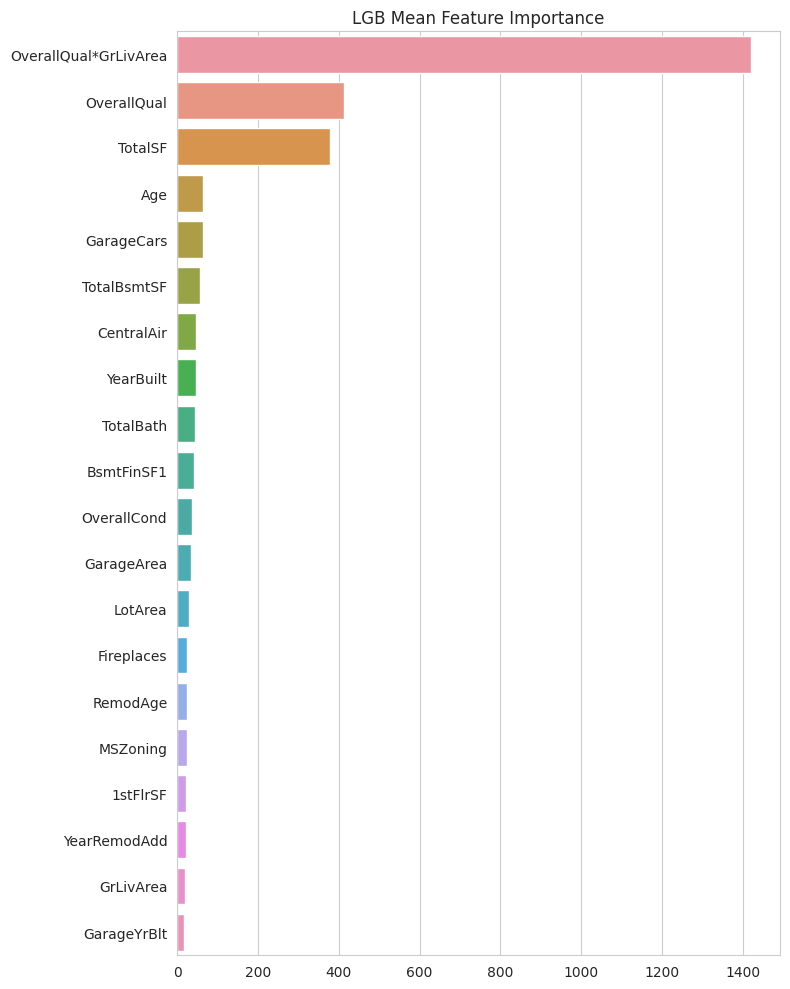

XGBoost mean feature importance:


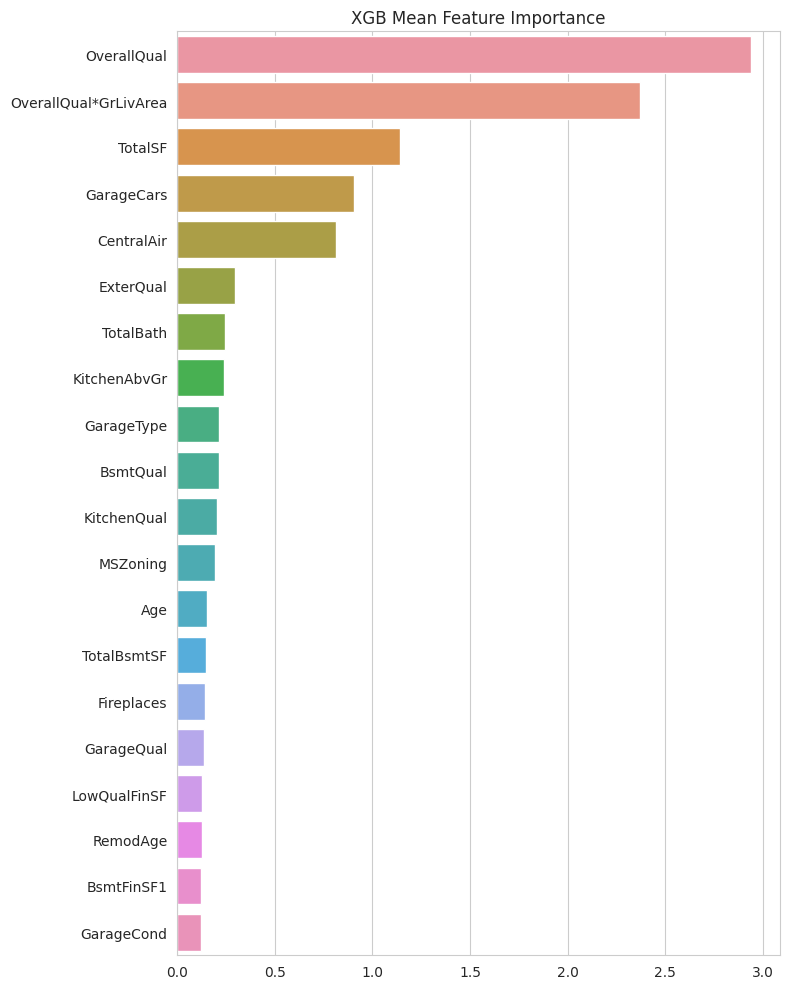

Done. Submission saved as submission.csv


In [3]:
# CLEAN, FIXED Ames Housing notebook - copy/paste into Kaggle
# Addresses XGBoost/LGB API changes and previous errors you encountered.

import warnings
warnings.filterwarnings("ignore")
import os, gc, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge

import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgb

sns.set_style("whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Environment versions:", "pandas", pd.__version__, "numpy", np.__version__, "xgboost", xgb.__version__, "lightgbm", lgb.__version__)

# --- 1) Load data (Kaggle paths) ---
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
sample_sub = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

# Keep Ids
test_ids = test['Id'].copy()

# --- 2) Target transform ---
train['SalePriceLog'] = np.log1p(train['SalePrice'])
y = train['SalePriceLog']  # keep as pandas Series

# --- 3) Combine for feature engineering ---
all_df = pd.concat([train.drop(columns=['SalePrice','SalePriceLog']), test], axis=0, ignore_index=True)

# --- 4) Feature engineering (robust) ---
def feature_engineer(df):
    # Basic combined features
    df['TotalSF'] = df[['TotalBsmtSF','1stFlrSF','2ndFlrSF']].fillna(0).sum(axis=1)
    df['TotalBath'] = df['FullBath'].fillna(0) + 0.5*df['HalfBath'].fillna(0) + df['BsmtFullBath'].fillna(0) + 0.5*df['BsmtHalfBath'].fillna(0)
    df['TotalPorchSF'] = df[['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].fillna(0).sum(axis=1)
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    df['HasPool'] = (df['PoolArea'].fillna(0) > 0).astype(int)
    df['HasGarage'] = (df['GarageArea'].fillna(0) > 0).astype(int)
    df['HasBsmt'] = (~df['BsmtFinSF1'].isnull()).astype(int)
    df['LivAreaPerRoom'] = df['GrLivArea'].fillna(0) / (df['TotRmsAbvGrd'].replace(0,1).fillna(1))
    df['OverallQual*GrLivArea'] = df['OverallQual'].fillna(0) * df['GrLivArea'].fillna(0)

    # Fill certain categorical NAs with 'None'
    cat_fill_none = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                     'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']
    for c in cat_fill_none:
        if c in df.columns:
            df[c] = df[c].fillna('None')

    # Numeric fill zeros for basement/garage related fields
    num_fill_zero = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
                     'BsmtFullBath','BsmtHalfBath','MasVnrArea','PoolArea','MiscVal']
    for c in num_fill_zero:
        if c in df.columns:
            df[c] = df[c].fillna(0)

    # LotFrontage by neighborhood median
    if 'LotFrontage' in df.columns and 'Neighborhood' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

    # Fill remaining categoricals and numerics
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = df[c].fillna('Missing')
    for c in df.select_dtypes(include=[np.number]).columns:
        df[c] = df[c].fillna(df[c].median())

    return df

all_df = feature_engineer(all_df)

# --- 5) Encoding (LabelEncoder) ---
obj_cols = all_df.select_dtypes(include=['object']).columns.tolist()
for col in obj_cols:
    le = LabelEncoder()
    all_df[col] = le.fit_transform(all_df[col].astype(str))

# --- 6) Split back ---
X = all_df.iloc[:len(train)].reset_index(drop=True)
X_test = all_df.iloc[len(train):].reset_index(drop=True)
y = y.reset_index(drop=True)  # ensure alignment

print("X shape:", X.shape, "X_test shape:", X_test.shape, "y shape:", y.shape)

# --- 7) Utilities ---
def rmse_log(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- 8) XGBoost OOF (updated for XGBoost >=2.x) ---
def run_xgb_oof(X_df, y_series, X_test_df, params=None, n_splits=5, num_boost_round=3000, early_stopping_rounds=100):
    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': 0.03,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'max_depth': 6,
            'reg_alpha': 0.001,
            'reg_lambda': 0.01,
            'seed': RANDOM_STATE,
            'verbosity': 0,
        }
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros(len(X_df))
    test_preds = np.zeros(len(X_test_df))
    fi_list = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_df)):
        print(f"XGB Fold {fold+1}/{n_splits}")
        X_tr = X_df.iloc[tr_idx]
        X_val = X_df.iloc[val_idx]
        y_tr = y_series.iloc[tr_idx]
        y_val = y_series.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalid = xgb.DMatrix(X_val, label=y_val)
        dtest = xgb.DMatrix(X_test_df)

        watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=num_boost_round,
            evals=watchlist,
            callbacks=[EarlyStopping(rounds=early_stopping_rounds, save_best=True)],
            # no verbose_eval for compatibility if needed; xgb.train supports verbose via callbacks
        )

        best_iter = getattr(model, "best_iteration", None)
        if best_iter is None:
            best_iter = num_boost_round

        val_pred = model.predict(dvalid, iteration_range=(0, best_iter + 1))
        test_pred = model.predict(dtest, iteration_range=(0, best_iter + 1))

        oof_preds[val_idx] = val_pred
        test_preds += test_pred / n_splits

        # safe feature importance (gain)
        score_dict = model.get_score(importance_type='gain') or {}
        fi = pd.Series(score_dict).reindex(X_df.columns).fillna(0)
        fi_list.append(fi)

        del dtrain, dvalid
        gc.collect()

    cv_score = rmse_log(y_series, oof_preds)
    fi_df = pd.concat(fi_list, axis=1).fillna(0)
    return oof_preds, test_preds, cv_score, fi_df

# --- 9) LightGBM OOF (updated for LightGBM >=4.x) ---
def run_lgb_oof(X_df, y_series, X_test_df, params=None, n_splits=5, num_boost_round=4000, early_stopping_rounds=100, log_period=200):
    if params is None:
        params = {
            'objective': 'regression',
            'metric': 'rmse',
            'learning_rate': 0.03,
            'num_leaves': 31,
            'min_child_samples': 20,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'reg_alpha': 0.1,
            'reg_lambda': 0.1,
            'seed': RANDOM_STATE,
            'verbosity': -1
        }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    oof_preds = np.zeros(len(X_df))
    test_preds = np.zeros(len(X_test_df))
    fi_list = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_df)):
        print(f"LGB Fold {fold+1}/{n_splits}")
        X_tr = X_df.iloc[tr_idx]
        X_val = X_df.iloc[val_idx]
        y_tr = y_series.iloc[tr_idx].to_numpy()
        y_val = y_series.iloc[val_idx].to_numpy()

        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_val, label=y_val)

        model = lgb.train(
            params=params,
            train_set=dtrain,
            num_boost_round=num_boost_round,
            valid_sets=[dvalid],
            callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds),
                       lgb.log_evaluation(period=log_period)]
        )

        best_iter = getattr(model, "best_iteration", None)
        if best_iter is None:
            best_iter = num_boost_round

        val_pred = model.predict(X_val, num_iteration=best_iter)
        test_pred = model.predict(X_test_df, num_iteration=best_iter)

        oof_preds[val_idx] = val_pred
        test_preds += test_pred / n_splits

        fi = pd.Series(model.feature_importance(importance_type='gain'), index=X_df.columns).fillna(0)
        fi_list.append(fi)

        del dtrain, dvalid, model
        gc.collect()

    cv_score = rmse_log(y_series, oof_preds)
    fi_df = pd.concat(fi_list, axis=1).fillna(0)
    return oof_preds, test_preds, cv_score, fi_df

# --- 10) Model parameters (adjust/tune later) ---
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.03,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'max_depth': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'seed': RANDOM_STATE,
    'verbosity': 0
}

lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'seed': RANDOM_STATE,
    'verbosity': -1
}

# --- 11) Run XGBoost OOF ---
print("Running XGBoost OOF...")
xgb_oof, xgb_test_preds, xgb_score, xgb_fi = run_xgb_oof(
    X, y, X_test,
    params=xgb_params,
    n_splits=5,
    num_boost_round=3000,
    early_stopping_rounds=100
)
print("XGBoost CV RMSE (log target):", xgb_score)

# --- 12) Run LightGBM OOF ---
print("Running LightGBM OOF...")
lgb_oof, lgb_test_preds, lgb_score, lgb_fi = run_lgb_oof(
    X, y, X_test,
    params=lgb_params,
    n_splits=5,
    num_boost_round=4000,
    early_stopping_rounds=100,
    log_period=200
)
print("LightGBM CV RMSE (log target):", lgb_score)

# --- 13) Simple stacking with Ridge using OOF preds ---
meta_train = np.vstack([xgb_oof, lgb_oof]).T
meta_test = np.vstack([xgb_test_preds, lgb_test_preds]).T
print("Meta shapes:", meta_train.shape, meta_test.shape)

meta_oof = np.zeros(meta_train.shape[0])
meta_test_preds = np.zeros(meta_test.shape[0])
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
fold_scores = []
for fold, (tr_idx, val_idx) in enumerate(kf.split(meta_train)):
    X_tr_m, X_val_m = meta_train[tr_idx], meta_train[val_idx]
    y_tr_m, y_val_m = y.iloc[tr_idx], y.iloc[val_idx]
    ridge = Ridge(alpha=1.0)
    ridge.fit(X_tr_m, y_tr_m)
    pred_val = ridge.predict(X_val_m)
    meta_oof[val_idx] = pred_val
    meta_test_preds += ridge.predict(meta_test) / kf.n_splits
    score = rmse_log(y_val_m, pred_val)
    fold_scores.append(score)
    print(f"Meta Fold {fold+1} RMSE: {score:.5f}")

print("Meta CV mean RMSE:", np.mean(fold_scores), "std:", np.std(fold_scores))

# --- 14) Final predictions & submission ---
final_test_log = meta_test_preds
final_test_price = np.expm1(final_test_log)

submission = pd.DataFrame({'Id': test_ids, 'SalePrice': final_test_price})
submission.to_csv('submission.csv', index=False)
print("Saved submission.csv (head):")
display(submission.head())

# --- 15) Feature importance quick view ---
def show_top_fi(fi_df, topn=20, title="Feature importance"):
    fi_mean = fi_df.mean(axis=1).sort_values(ascending=False).head(topn)
    plt.figure(figsize=(8, max(4, topn/2)))
    sns.barplot(x=fi_mean.values, y=fi_mean.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("LightGBM mean feature importance:")
show_top_fi(lgb_fi, topn=20, title="LGB Mean Feature Importance")
print("XGBoost mean feature importance:")
show_top_fi(xgb_fi, topn=20, title="XGB Mean Feature Importance")

print("Done. Submission saved as submission.csv")
